###  1.1 Import DATA

In [80]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from numpy import mean
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import plot_det_curve
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler

df_recipes = pd.read_csv('../dataset/recipes.csv')
df_recipe_with_ingredient = pd.read_csv('../dataset/recipe_with_ingredient.csv')
food_df = pd.read_csv('../dataset/food.csv')
ingred_spices_df = pd.read_csv('collect_spices_ingred_df.csv')

### 1.2 Label Target 

In [81]:
add_col = ['carbohydrate_p','protein_p','fat_p']
map_to_col = ['carbohydrate','protein','fat']

# Protein - 4 calories per gram
# Fats - 9 calories per gram
# Carbs - 4 calories per gram
macronutrient_basics = [4,4,9]

for i in range(3):
    df_recipes[add_col[i]] = ((df_recipes[map_to_col[i]]*macronutrient_basics[i]/df_recipes['calories'])*100).round(1)

"""
Label Keto
"""
# 1 = Keto Diet 
# 0 = not Keto Diet 
df_recipes['label_keto'] = 0
c = df_recipes['carbohydrate_p']
p = df_recipes['protein_p']
f = df_recipes['fat_p']
label = df_recipes['label_keto']
for i in range(df_recipes.shape[0]):
    if  f.loc[i] >= 70 and c.loc[i] <= 10:
        label.loc[i] = 1

# select the features to keep to join another table 
df_recipes_keto = df_recipes[['recipe_id','label_keto']]
# merge the selected features with df_recipe_with_ingredient
df_recipe_with_ingredient.rename({'Unnamed: 0':'recipe_id'}, axis='columns', inplace = True)
join_recipe_w_label = df_recipe_with_ingredient.set_index('recipe_id').join(df_recipes_keto.set_index('recipe_id'))
join_recipe_w_label.shape

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(3365, 3803)

### 1.3 Drop outliers (spices)

In [82]:
# Drop the spices ingredients
join_recipe_w_label = join_recipe_w_label.drop(labels = [str(x) for x in ingred_spices_df.food_id.values], axis = 1)
features = [x for x in join_recipe_w_label.columns[0:-1]]
join_recipe_w_label.shape

(3365, 3207)

In [83]:
# drop duplicates
join_recipe_w_label = join_recipe_w_label[join_recipe_w_label.iloc[:, 0:join_recipe_w_label.shape[1] - 1].duplicated() == False]
print(f'The size of dataframe after drop rows with no ingredient {join_recipe_w_label.shape}')

The size of dataframe after drop rows with no ingredient (3298, 3207)


#### Optional

In [84]:
def undersampleNegative(df, label, coef=1):
    positive_label_df = df[df[label] == 1]
    negative_label_df = df[df[label] == 0]
    negative_undersampled = negative_label_df.sample(n= round(coef * len(positive_label_df)))
    return pd.concat([positive_label_df, negative_undersampled ], axis= 0)

def tryFeaturePercent(df,params):
    best_accracy, best_percent = 0, 0
    for p in params:
        temp_df = df.loc[:, df.sum(axis=0)/df.shape[0] >= p]
        X, y = df.iloc[:, 1:df.shape[1] - 1], df.iloc[:, df.shape[1] - 1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
        rf = RandomForestClassifier() 
        rf = rf.fit(X_train, y_train)
        cur_acc = metrics.accuracy_score(y_test, rf.predict(X_test))
        if cur_acc >= best_accracy:
            best_percent = p
            best_accracy = cur_acc
    return best_percent, best_accracy

def tryDiffRandomState(params):
    best_params = []
    for p in params:
        feature_select_df = undersampleNegative(join_recipe_w_label, 'label_keto', 1)
        cur_best_percent, cur_best_acc  = tryFeaturePercent(feature_select_df, np.linspace(0.0001, 0.005, 30))
        best_params.append(cur_best_percent)
    return best_params

def viewIngredient(df):
    to_int_lst = []
    for i in df.columns[1: df.shape[1] - 1]:
        to_int_lst.append(int(i))
    return food_df[food_df['food_id'].isin(to_int_lst)]

In [85]:
# find params to cut rare features
# This cell takes about 3 min to run (deppeding on the size of iterable passed in)

params = tryDiffRandomState(range(0,10))
print(f'The pramas in each iteration to select features are {params}')
temp = params
optimal_params = np.mean(temp)
optimal_join_recipe_w_label = join_recipe_w_label.loc[:, join_recipe_w_label.sum(axis=0)/join_recipe_w_label.shape[0] >= optimal_params]
print(f'mean optimal_params: {optimal_params} \nThe size of dataframe after selection {optimal_join_recipe_w_label.shape}')
features = [x for x in optimal_join_recipe_w_label.columns[0:-1]]
join_recipe_w_label = optimal_join_recipe_w_label

The pramas in each iteration to select features are [0.0043241379310344835, 0.0041551724137931035, 0.0034793103448275864, 0.004662068965517242, 0.004493103448275863, 0.0017896551724137933, 0.0031413793103448277, 0.0031413793103448277, 0.004662068965517242, 0.0043241379310344835]
mean optimal_params: 0.003817241379310345 
The size of dataframe after selection (3298, 221)


In [86]:
# drop duplicates
join_recipe_w_label = join_recipe_w_label[join_recipe_w_label.iloc[:, 0:join_recipe_w_label.shape[1] - 1].duplicated() == False]
print(f'The size of dataframe after drop rows with no ingredient {join_recipe_w_label.shape}')

The size of dataframe after drop rows with no ingredient (2613, 221)


In [74]:
rank_ingred = recipe_with_ingred.sum(axis=0)
ingred_count = pd.DataFrame(zip([int(x) for x in rank_ingred.keys()[0:]],rank_ingred.values[0:]),columns=['food_id','count'])

ingred_count = ingred_count.sort_values("count", ascending = False)
ingred_count_w_name = ingred_count.set_index('food_id').join(food_df.set_index('food_id'))
ingred_count_w_name
# viewIngredient(join_recipe_w_label)

,count,food_name
food_id,,
36442,839,Onions
33792,262,Egg (Whole)
36633,238,Red Tomatoes
36320,224,Carrots
3092,220,Egg
...,...,...
77671,11,Boneless Skinless Chicken Breast
36281,11,Green Snap Beans (Frozen)
27572,10,Old Fashioned Oats


### 1.4 Split dataset into train and test set

In [87]:

# label 1 as postive sample and 0 as negative sample
p_sample = join_recipe_w_label[join_recipe_w_label['label_keto'] == 1]
n_sample = join_recipe_w_label[join_recipe_w_label.label_keto == 0]
# randomly sample negative samples from the pool to have same data size as postive samples
n_sample_rand = n_sample.sample(n = len(p_sample),random_state =0)
X = pd.concat([p_sample, n_sample_rand])
y =  X.label_keto
X_ = X[features]
x_train, x_test, y_train, y_test = train_test_split(X_,y, test_size=0.2, random_state=0)

# print(f"class counts in traning set: {Counter(X.label_keto)}")

# Model Building and Training
<hr />

In [88]:
def printAccruacy(model_name, actual_test, predictions_test, actual_train=None, predictions_train=None):
    print(f'The accuracy of {model_name} is: {metrics.accuracy_score(actual_test, predictions_test)}')
    if actual_train is not None and predictions_train is not None:
        print(f'The accuracy of {model_name} on training set is: {metrics.accuracy_score(actual_train, predictions_train)}')
    
def printCVscore(model, x_train, y_train, cv=10):
    score = np.mean(cross_validate(model, x_train, y_train, cv=cv)['test_score'])
    print(f'The mean CV score using {cv}-fold coross validation is: {score}')
    return score

#### logistic regression 

In [89]:
C = np.linspace(0.001, 3, 20)
param_grid = dict(C=C)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
lg_grid_search = GridSearchCV(LogisticRegression(),param_grid = param_grid, cv = cv, n_jobs=-1)
lg_grid_search.fit(x_train, y_train)

# View the best parameters from the random search
print(lg_grid_search.best_params_)
lg_best_params = lg_grid_search.best_params_

# logistic regression 
lr = LogisticRegression(C = lg_best_params['C'], random_state=1)
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
# accuracy = accuracy_score(y_test,y_pred)*100
print('LR:\n',metrics.classification_report(y_test,y_pred_lr))
printAccruacy('lg model', y_test, y_pred_lr, y_train, lr.predict(x_train))
score = printCVscore(lr, x_train, y_train)

{'C': 0.4745263157894737}
LR:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.83      0.83      0.83        18

    accuracy                           0.85        41
   macro avg       0.85      0.85      0.85        41
weighted avg       0.85      0.85      0.85        41

The accuracy of lg model is: 0.8536585365853658
The accuracy of lg model on training set is: 0.9627329192546584
The mean CV score using 10-fold coross validation is: 0.7823529411764706


#### Random Forest

In [90]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 10)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['sqrt', 'log2']

# Criterion to split on
rf_criterion = ['gini', 'entropy']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 100, 10)]


# # Method of selecting samples for training each tree
# rf_bootstrap = [True, False]


rf_min_samples_leaf = [2, 4, 6]
# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_leaf': rf_min_samples_leaf,
               'min_samples_split': rf_min_samples_split,
               }

from sklearn.model_selection import RandomizedSearchCV
# Create the model to be tuned
rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, scoring='f1',
                               n_iter = 100, cv = 5, verbose = True, random_state = 2, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train, y_train)

# View the best parameters from the random search
rf_random.best_params_
rf_best_params = rf_random.best_params_

# example of evaluating a decision tree with random undersampling
rf = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                            min_samples_split= rf_best_params['min_samples_split'],
                            max_features= rf_best_params['max_features'],
                            max_depth= rf_best_params['max_depth'],
                            criterion= rf_best_params['criterion'],
                           random_state = 1)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)

# accuracy = accuracy_score(y_test,y_pred)*100
print('RF:\n',metrics.classification_report(y_test,y_pred_rf))
printAccruacy('random forest', y_test, y_pred_rf, y_train, rf.predict(x_train))
printCVscore(rf, x_train, y_train, 10)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RF:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        23
           1       0.79      0.83      0.81        18

    accuracy                           0.83        41
   macro avg       0.83      0.83      0.83        41
weighted avg       0.83      0.83      0.83        41

The accuracy of random forest is: 0.8292682926829268
The accuracy of random forest on training set is: 0.9627329192546584
The mean CV score using 10-fold coross validation is: 0.7889705882352941


0.7889705882352941

#### SVM

In [91]:
Cs = np.linspace(0.001, 2, 50)
svc_grid = {'C': Cs}

svc_grid_search = GridSearchCV(SVC(kernel='rbf'), svc_grid, cv=10, n_jobs = -1, verbose = 2)
svc_grid_search.fit(x_train, y_train)
# View the best parameters from the random search
print(svc_grid_search.best_params_)
svc_best_params = svc_grid_search.best_params_

SupportVectorClassModel = SVC( C = svc_best_params['C'])
SupportVectorClassModel.fit(x_train,y_train)
y_pred = SupportVectorClassModel.predict(x_test)
# accuracy = accuracy_score(y_test,y_pred)*100
print('SVM:\n',metrics.classification_report(y_test,y_pred))
printAccruacy('SVC model', y_test, y_pred, y_train, SupportVectorClassModel.predict(x_train))
print(np.mean(cross_validate(SupportVectorClassModel, x_train, y_train, cv=10)['test_score']))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'C': 2.0}
SVM:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        23
           1       0.79      0.83      0.81        18

    accuracy                           0.83        41
   macro avg       0.83      0.83      0.83        41
weighted avg       0.83      0.83      0.83        41

The accuracy of SVC model is: 0.8292682926829268
The accuracy of SVC model on training set is: 0.9937888198757764
0.8261029411764707


#### Navie Bayes

In [92]:
from sklearn.naive_bayes import BernoulliNB
params = {'alpha': np.linspace(0.001, 2, 40)}
bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
bernoulli_nb_grid.fit(x_train,y_train)

# View the best parameters from the random search
print(bernoulli_nb_grid.best_params_)
nb_best_params = bernoulli_nb_grid.best_params_

# Naive Bayes 
nb = BernoulliNB( alpha = nb_best_params['alpha'])
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
# accuracy = accuracy_score(y_test,y_pred)*100
print('NB:\n',metrics.classification_report(y_test,y_pred_nb))
printAccruacy('NB model', y_test, y_pred_nb, y_train, nb.predict(x_train))
score = printCVscore(nb, x_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
{'alpha': 0.5648205128205128}
NB:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.83      0.83      0.83        18

    accuracy                           0.85        41
   macro avg       0.85      0.85      0.85        41
weighted avg       0.85      0.85      0.85        41

The accuracy of NB model is: 0.8536585365853658
The accuracy of NB model on training set is: 0.9316770186335404
The mean CV score using 10-fold coross validation is: 0.7944852941176471


# ROC Graph

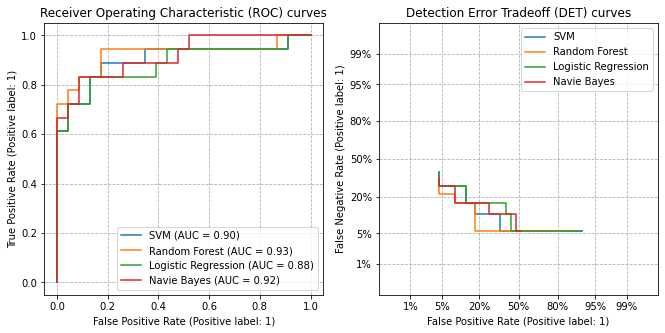

In [94]:
N_SAMPLES = 1000

classifiers = {
    "SVM": SupportVectorClassModel,
    "Random Forest": rf ,
    "Logistic Regression": lr ,
    "Navie Bayes": nb
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(x_train, y_train)

    plot_roc_curve(clf, x_test, y_test, ax=ax_roc, name=name)
    plot_det_curve(clf, x_test, y_test, ax=ax_det, name=name)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_det.set_title('Detection Error Tradeoff (DET) curves')

ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')

plt.legend()
plt.show()

SVM
Random Forest
Logistic Regression
Navie Bayes


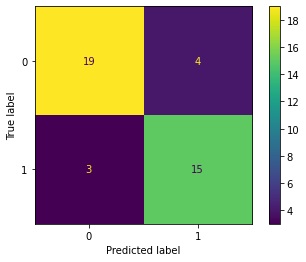

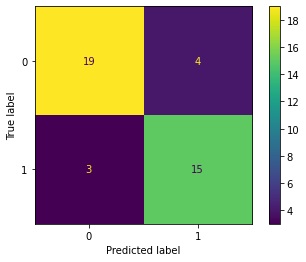

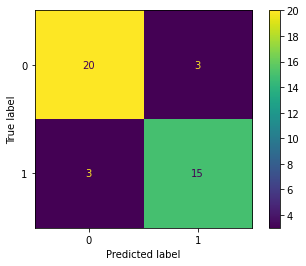

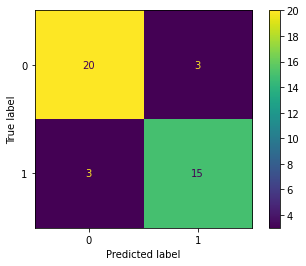

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for name, clf in classifiers.items():
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    print(name)
plt.show()

## Pickle

In [ ]:
models = {'lg_model': lr, 'rf_model': rf, 'svc_model': SupportVectorClassModel, 'nb_model': nb}
info = {'df': X, 'models': models}

with open("./keto_final_info.pickle","wb") as f:
    pickle.dump(info, f)